In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [3]:
data_dir = '/content/drive/MyDrive/ANN/MP2/notes/wav'
filenames = tf.io.gfile.glob(str(data_dir) + '/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 12414
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/ANN/MP2/notes/wav/121_72.wav', shape=(), dtype=string)


In [4]:
train_files = filenames[:9000]
val_files = filenames[9000: 9000 + 2100]
test_files = filenames[-1324:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

cnt_prt_train = np.repeat(np.arange(4), len(train_files))
cnt_prt_val   = np.repeat(np.arange(4), len(val_files))
cnt_prt_test  = np.repeat(np.arange(4), len(test_files))

train_files = np.tile(train_files, 4)
val_files   = np.tile(val_files, 4)
test_files  = np.tile(test_files, 4)

train_files.shape, cnt_prt_train.shape

Training set size 9000
Validation set size 2100
Test set size 1324


((36000,), (36000,))

In [5]:
test_file = tf.io.read_file('/content/drive/MyDrive/ANN/MP2/notes/wav/60_35.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio[:11000,0][:,None].shape

TensorShape([11000, 1])

In [6]:
def decode_audio(audio_binary, part):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, rate = tf.audio.decode_wav(contents=audio_binary)

    part = tf.cast(part, dtype=tf.int32)
    ln = rate//4
    audio = tf.experimental.numpy.mean(audio[ln*part:ln*(part+1)], axis=1)
    audio = audio[:,None]
    return tf.squeeze(audio, axis=-1)

In [7]:
def get_label(file_path): 
    res = tf.strings.split(file_path, sep='_')
    res2 = tf.strings.split(res[-1], sep='.')
    return res2[0]

In [8]:
def get_waveform_and_label(file_path, part):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary, part)
    return waveform, label

In [9]:
%%time
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices((train_files, cnt_prt_train))

waveform_ds = files_ds.map(
    map_func = get_waveform_and_label,
    num_parallel_calls=AUTOTUNE
    )

CPU times: user 289 ms, sys: 0 ns, total: 289 ms
Wall time: 295 ms


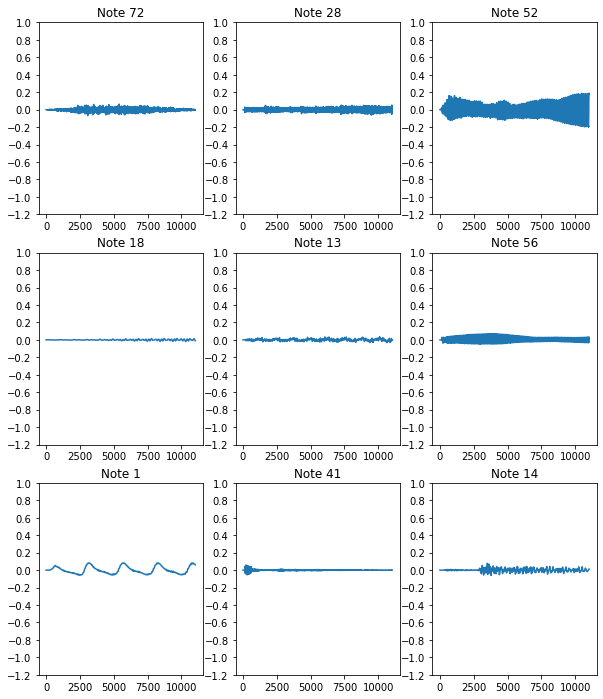

In [10]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(f'Note {label}')
    
plt.show()

In [11]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 12000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [12000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [12]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=12000))

Label: 72
Waveform shape: (11025,)
Spectrogram shape: (92, 129, 1)
Audio playback


In [13]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

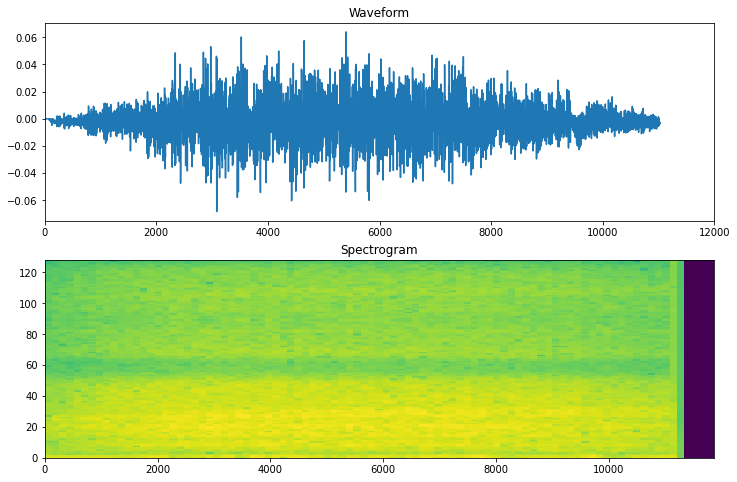

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 12000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [15]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.strings.to_number(label, tf.int32)
    return spectrogram, label_id

In [16]:
%%time
spectrogram_ds = waveform_ds.map(
    map_func=get_spectrogram_and_label_id,
    num_parallel_calls=AUTOTUNE
)

CPU times: user 220 ms, sys: 0 ns, total: 220 ms
Wall time: 223 ms


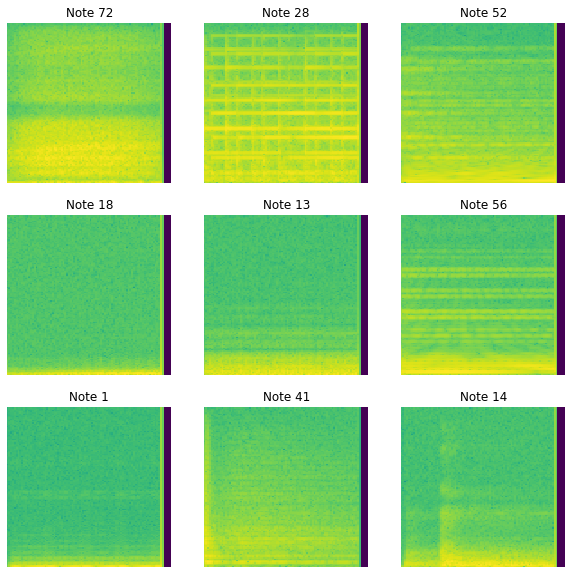

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(f'Note {label_id.numpy()}')
    ax.axis('off')

plt.show()

In [18]:
def preprocess_dataset(files, cnt_prt):
    files_ds = tf.data.Dataset.from_tensor_slices((files, cnt_prt))
    output_ds = files_ds.map(
        map_func = get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [19]:
%%time
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files, cnt_prt_val)
test_ds = preprocess_dataset(test_files, cnt_prt_test)

CPU times: user 419 ms, sys: 0 ns, total: 419 ms
Wall time: 429 ms


In [20]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [21]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [22]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

Input shape: (92, 129, 1)


In [23]:
num_labels = 108

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(64, 64),
    # Normalize.
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 64, 64, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 128)       0

In [24]:
%%time
fit_callbacks = [
                 tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 4, 
                                                  restore_best_weights = True, verbose = 1)
]
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks = fit_callbacks)

Epoch 1/100
563/563 [==============================] - 212s 370ms/step - loss: 3.3190 - accuracy: 0.2343 - val_loss: 2.7947 - val_accuracy: 0.3225
Epoch 2/100
563/563 [==============================] - 47s 84ms/step - loss: 2.6404 - accuracy: 0.3305 - val_loss: 2.5593 - val_accuracy: 0.3676
Epoch 3/100
563/563 [==============================] - 47s 84ms/step - loss: 2.3766 - accuracy: 0.3762 - val_loss: 2.4073 - val_accuracy: 0.3998
Epoch 4/100
563/563 [==============================] - 47s 83ms/step - loss: 2.1827 - accuracy: 0.4156 - val_loss: 2.3536 - val_accuracy: 0.4177
Epoch 5/100
563/563 [==============================] - 47s 83ms/step - loss: 2.0339 - accuracy: 0.4503 - val_loss: 2.2730 - val_accuracy: 0.4508
Epoch 6/100
563/563 [==============================] - 47s 83ms/step - loss: 1.9051 - accuracy: 0.4799 - val_loss: 2.2048 - val_accuracy: 0.4760
Epoch 7/100
563/563 [==============================] - 47s 83ms/step - loss: 1.8113 - accuracy: 0.5019 - val_loss: 2.1562 - val_

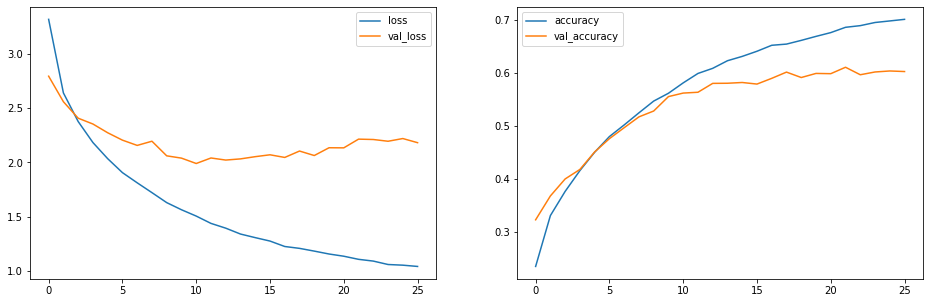

In [25]:
metrics = history.history
fig, axes = plt.subplots(1,2, figsize=(16,5))
for ax, mtr in zip(axes.flat, [('loss', 'val_loss'), ('accuracy', 'val_accuracy')]):
    ax.plot(history.epoch, metrics[mtr[0]], metrics[mtr[1]])
    ax.legend([mtr[0], mtr[1]])
plt.show()

In [26]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 60%


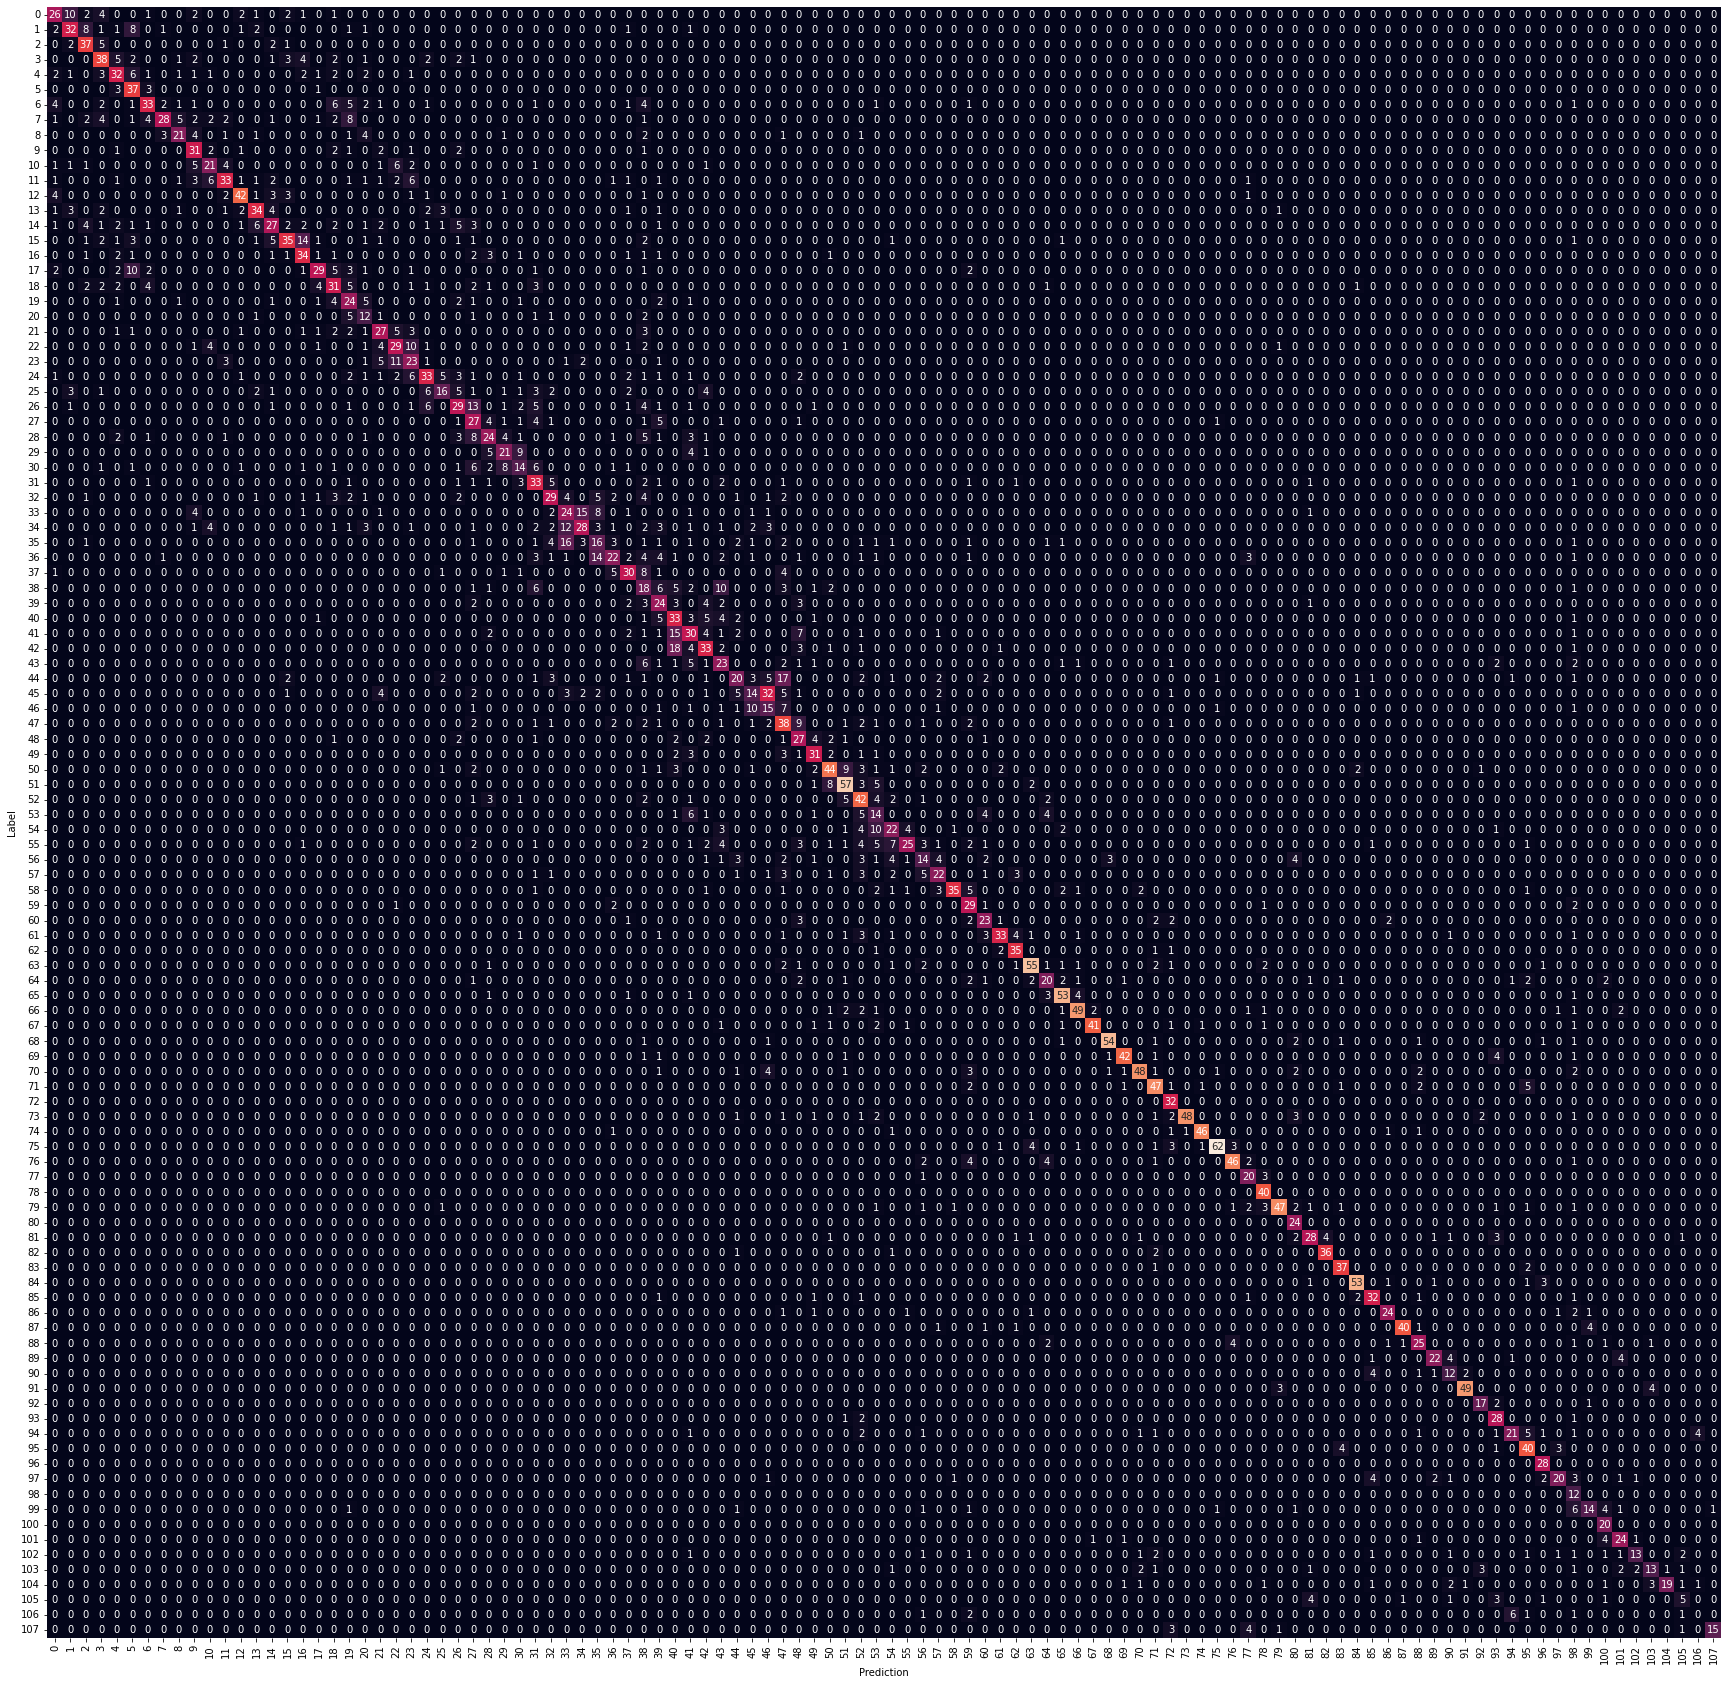

In [29]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(30, 30))
sns.heatmap(confusion_mtx,
            xticklabels=np.arange(108),
            yticklabels=np.arange(108),
            annot=True, fmt='g', cbar=0
            )

plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()